In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt # 데이터 시각화
import seaborn as sns
import missingno as msno
import os
import re
import multiprocessing # 여러 개의 일꾼 (cpu)들에게 작업을 분산시키는 역할
from multiprocessing import Pool 
from functools import partial # 함수가 받는 인자들 중 몇개를 고정 시켜서 새롭게 파생된 함수를 형성하는 역할
from my_data_loader import my_data_loader 

%matplotlib inline
plt.rcParams["figure.figsize"] = (13,10)

In [2]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Embedding
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.utils import np_utils
import keras
import lightgbm as lgb
seed = 5

Using TensorFlow backend.


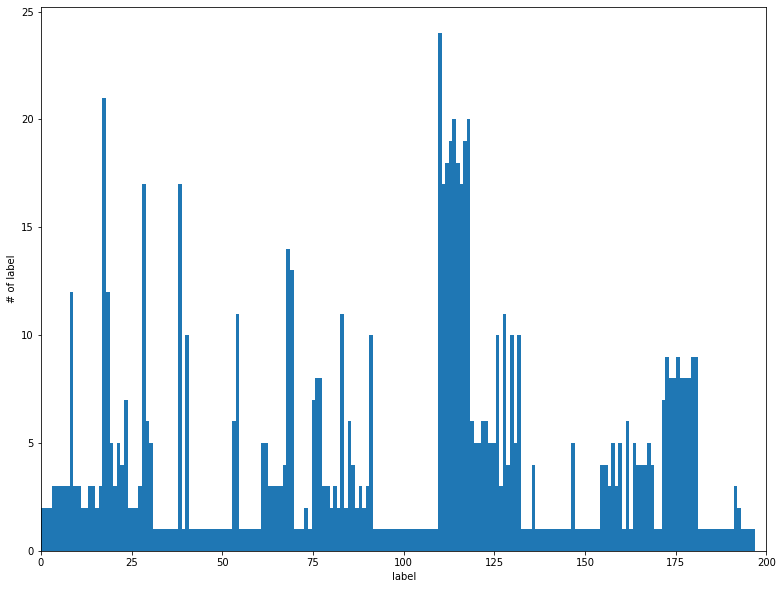

In [3]:
train_label = pd.read_csv("train_label.csv")
plt.hist(train_label['label'], bins=len(train_label['label'].unique()))
plt.xlim(0,200)
plt.ylim(bottom=0)
plt.xlabel('label')
plt.ylabel('# of label')
plt.show()

In [4]:
# 전체적으로 Imbalance Data, 1개뿐인 라벨이 많음

In [5]:
# Bad, CLOSE, Equip Fail, No Data, Normal, OFF, ON, OPEN, System.Char[] 등 문자열 데이터를 포함

In [6]:
realData1 = "Train/30.csv"
realData2 = "Test/1154.csv"
realData3 = "Test/1168.csv"
realData4 = "additinal_data/additinal_data1"
realData5 = "additinal_data/additinal_data2"

In [3]:
train_folder = 'train/'
test_folder = 'test/'
train_label_path = 'train_label.csv'

In [4]:
train_list = os.listdir(train_folder)
test_list = os.listdir(test_folder)
train_label = pd.read_csv(train_label_path, index_col=0)

# DataPreprocessn  

In [6]:
# 모든 csv 파일의 상태_B로 변화는 시점이 1~15초 랜덤으로 가정
def my_data_loader_all(func, files, folder='', train_label=None, event_time=10, nrows=60):   
    func_fixed = partial(func, folder=folder, train_label=train_label, event_time=event_time, nrows=nrows)     
    if __name__ == '__main__':
        pool = Pool(processes=multiprocessing.cpu_count()) 
        df_list = list(pool.imap(func_fixed, files)) 
        pool.close()
        pool.join()        
    combined_df = pd.concat(df_list)    
    return combined_df

In [5]:
#train = my_data_loader_all(my_data_loader, train_list, folder=train_folder, train_label=train_label, event_time=10, nrows=60)
train = pd.read_csv("train_v1.csv")

In [6]:
# 모든 test 셋 데이터에 대해서 1~15초부터 랜덤하게 상태_B가 시작된다고 가정 
#test = my_data_loader_all(my_data_loader, test_list, folder=test_folder, train_label=None, event_time=10, nrows=60)
test = pd.read_csv("test_v1.csv")

In [69]:
#train.to_csv("train_v1.csv")
#test.to_csv("test_v1.csv")

In [7]:
train_1 = train.copy()
train_y = train_1['label']
train_1 = train_1.drop(['label'], axis=1)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(train_1, train_y, test_size=0.2, random_state=seed)
print(X_train,X_test,Y_train,Y_test)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

       Unnamed: 0      V0000     V0001     V0002     V0003     V0004  \
15818         645  30.469176  8.680222  8.718171  8.727309  8.694180   
5290          369  30.474732  8.794888  8.708693  8.693407  8.725450   
16265         269  30.483363  8.677149  8.691058  8.661279  8.733543   
11910         346  30.468302  8.704963  8.708931  8.711129  8.701583   
33893         821  30.482572  8.817756  8.719177  8.820185  8.711986   
...           ...        ...       ...       ...       ...       ...   
5520          816  30.472774  8.675617  8.714310  8.704230  8.673045   
35814         771  30.469492  8.733404  8.709039  8.694300  8.693976   
20463         482  30.465643  8.823523  8.729735  8.694199  8.612927   
18638         732  30.474946  8.764901  8.710119  8.660449  8.689067   
35683         567  30.464810  8.756298  8.691154  8.698040  8.695485   

            V0005       V0006         V0007  V0008  ...  V5111  V5112  V5113  \
15818  212.117293  243.249118 -2.447466e-19    0.0  ...

# RandomForestClaasifier

In [57]:
model = RandomForestClassifier(random_state=0, verbose=1, n_jobs=-1)
model.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=1,
                       warm_start=False)

In [61]:
expected_y  = Y_test
predicted_y = model.predict(X_test).round()
print(); print('RandomForestClassifier: ')
print(); print(metrics.classification_report(expected_y, predicted_y))
print(); print(metrics.confusion_matrix(expected_y, predicted_y))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s



RandomForestClassifier: 

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        20
           1       1.00      0.47      0.64        17
           2       0.95      0.82      0.88        22
           3       0.91      0.80      0.85        25
           4       0.96      0.71      0.82        38
           5       1.00      0.85      0.92        41
           6       1.00      0.92      0.96        37
           7       1.00      0.93      0.96        28
           8       0.68      0.92      0.78       125
           9       0.23      0.11      0.15        28
          10       0.33      0.75      0.46        32
          11       0.00      0.00      0.00        22
          12       0.88      0.28      0.42        25
          13       1.00      0.06      0.11        35
          14       0.25      0.27      0.26        30
          15       0.60      0.56      0.58        16
          16       0.40      0.29      0.33        35


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.0s finished
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LightGBM

In [10]:
X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]

train_ds = lgb.Dataset(X_train, label = Y_train)
test_ds = lgb.Dataset(X_test, label = Y_test)

In [11]:
model = lgb.LGBMClassifier()
#model.fit(X_train,Y_train)
lgb_params = {
        'objective':'multiclass',
        'boosting_type':'gbdt', #gradient boosting decision tree
        'metric':'multi_logloss',
        'num_class':198,
        'learning_rate':0.02,
        'seed': 5,
        'n_jobs': -1
    }

In [12]:
model = lgb.train(lgb_params, train_ds, 100, test_ds, verbose_eval=True, early_stopping_rounds=20)

[1]	valid_0's multi_logloss: 3.28624
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 3.02749
[3]	valid_0's multi_logloss: 2.84508
[4]	valid_0's multi_logloss: 2.69981
[5]	valid_0's multi_logloss: 2.57696
[6]	valid_0's multi_logloss: 2.47148
[7]	valid_0's multi_logloss: 2.37878
[8]	valid_0's multi_logloss: 2.29634
[9]	valid_0's multi_logloss: 2.22167
[10]	valid_0's multi_logloss: 2.15358
[11]	valid_0's multi_logloss: 2.09138
[12]	valid_0's multi_logloss: 2.03358
[13]	valid_0's multi_logloss: 1.97991
[14]	valid_0's multi_logloss: 1.92964
[15]	valid_0's multi_logloss: 1.88244
[16]	valid_0's multi_logloss: 1.83787
[17]	valid_0's multi_logloss: 1.79593
[18]	valid_0's multi_logloss: 1.75591
[19]	valid_0's multi_logloss: 1.718
[20]	valid_0's multi_logloss: 1.68209
[21]	valid_0's multi_logloss: 1.64778
[22]	valid_0's multi_logloss: 1.61461
[23]	valid_0's multi_logloss: 1.58296
[24]	valid_0's multi_logloss: 1.55287
[25]	valid_0's multi_logloss: 1.5239
[

In [13]:
import joblib
joblib.dump(model, 'lgbmodel.pkl')

['lgbmodel.pkl']

In [23]:
model = joblib.load('lgbmodel.pkl')

In [34]:
model2 = lgb.LGBMClassifier.predict_proba(lgb_params, train_ds, 100, test_ds, verbose_eval=True, early_stopping_rounds=20)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [33]:
expected_y  = Y_test
predicted_y = model.predict(X_test).round()
print(); print('LightGBM: ')
print(predicted_y)
#print(); print(metrics.classification_report(expected_y, predicted_y))
#print(); print(metrics.confusion_matrix(expected_y, predicted_y))


LightGBM: 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [24]:
pred = model.predict_proba(test)
submission = pd.DataFrame(data=pred)
submission.index = test.index
submission.index.name = 'id'
submission = submission.sort_index()
submission = submission.groupby('id').mean()
submission.to_csv('submission_1.csv', index=True) #제출 파일 만들기

AttributeError: 'Booster' object has no attribute 'predict_proba'